In [1]:
# load a matrix from a space-separated file and show it as an image
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import torch
import sys
sys.path.append('../..')
sys.path.append('/homes/ar2342/one_more_dir/contextual_frogs/')
sys.path.append('/homes/ar2342/one_more_dir/contextual_frogs/experimental/optim/')
from models import LegacyElboGenerativeModelTop,ElboGenerativeModelTop, ElboGenerativeModelDualRate
from types import SimpleNamespace
import copy
from optimise_clnn import load_subject_data
from model_utils import eval_ys, remove_gen

import os
from matplotlib.patches import FancyArrow


In [2]:
sys.path.append('/homes/ar2342/one_more_dir/contextual_frogs/experimental/optim/')
from optimise_clnn import eval_paradigms

In [3]:
from math import exp, log

def variance_from_entropy(h_nats: float) -> float:
    """
    Compute the variance of a 1D Gaussian from its differential entropy (in nats).

    Parameters
    ----------
    h_nats : float
        Differential entropy in nats.

    Returns
    -------
    float
        Variance sigma^2.
    """
    return exp(2.0 * h_nats - log(2.0 * np.pi * np.exp(1)))

print(variance_from_entropy(-1.0))


0.007923858032799689


In [4]:
# from collections.abc import Mapping

# def remove_gen(row_params: Mapping, prefix: str = "gen", require: bool = True) -> dict:
#     """
#     Filter a flat state_dict-like mapping to only <prefix>.* keys and strip the '<prefix>.' part.

#     Args:
#         row_params: Mapping of parameter names -> tensors (e.g., a state_dict row).
#         prefix:     Top-level prefix to keep (default: 'gen').
#         require:    If True, raise a ValueError when no <prefix>. keys are found.

#     Returns:
#         A new dict suitable for model.load_state_dict(...), with the prefix removed.
#     """
#     pre = f"{prefix}."
#     out = {k[len(pre):]: v for k, v in row_params.items() if isinstance(k, str) and k.startswith(pre)}
#     if require and not out:
#         raise ValueError(f"No keys found starting with '{pre}'")
#     return out

In [5]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
args = SimpleNamespace(model='default',
                       enable_q_scale_tuning=False,
                       assume_opt_output_noise=True, 
                       enable_qlpf=False,
                       enable_ylpf=False,
                       enable_elpf=False,
                       noise_injection_node='u',
                       model_tie_lr_weight_decay=True,
                       bs=512,
                       zzz_legacy_init=False,
                       enable_output_scale_tuning=True,
                       enable_u_feedback_scale_tuning=False,
                       n=128)
args_dual = copy.copy(args)
args_dual.noise_injection_node='x'
args_clnn_new = copy.copy(args)
# --enable-u-feedback-scale-tuning 
# --disable-output-scale-tuning
args_clnn_new.enable_output_scale_tuning=False
args_clnn_new.enable_u_feedback_scale_tuning=True
args_dual_a = copy.copy(args)
args_dual_a.noise_injection_node='a'
args_clnn_a = copy.copy(args)
args_clnn_a.noise_injection_node='a'
args_clnn_a = copy.copy(args)
args_clnn_a.noise_injection_node='a'
models  = {'clnn': LegacyElboGenerativeModelTop(device=device, args=args),
           'clnn_new': ElboGenerativeModelTop(device=device, args=args_clnn_new),
           'clnn_a': LegacyElboGenerativeModelTop(device=device, args=args_clnn_a),
           'dual': ElboGenerativeModelDualRate(device=device, args=args_dual),
           'dual_a': ElboGenerativeModelDualRate(device=device, args=args_dual_a),
            }

# models  = {'clnn_new': ElboGenerativeModelTop(device=device, args=args_clnn_new),
#            'dual_a': ElboGenerativeModelDualRate(device=device, args=args_dual_a),
#             }

In [6]:
args

namespace(model='default',
          enable_q_scale_tuning=False,
          assume_opt_output_noise=True,
          enable_qlpf=False,
          enable_ylpf=False,
          enable_elpf=False,
          noise_injection_node='u',
          model_tie_lr_weight_decay=True,
          bs=512,
          zzz_legacy_init=False,
          enable_output_scale_tuning=True,
          enable_u_feedback_scale_tuning=False,
          n=128)

In [7]:
experimental_data = {}
params = {k:{} for k in models.keys()}
paradigm_ = {k: 'evoked' if k <= 8 else 'spontaneous' for k in range(1,17)}

# for i in range(1,17):
#     params['clnn'][i] = torch.load(f'/homes/ar2342/one_more_dir/contextual_frogs/experimental/optim/results/realthing403uuu_seedsFX/run{i}_seed1/params.pt', map_location=device)
#     params['clnn_new'][i] = torch.load(f'/homes/ar2342/one_more_dir/contextual_frogs/experimental/optim/results/realthing403uuuUfb_seedsREF1/run{i}_seed1/params.pt', map_location=device)
#     params['clnn_a'][i] = torch.load(f'/homes/ar2342/one_more_dir/contextual_frogs/experimental/optim/results/realthing403ctrl_seedsFX/run{i}_seed1/params.pt', map_location=device)
#     params['dual'][i] = torch.load(f'/homes/ar2342/one_more_dir/contextual_frogs/experimental/optim/results/realthing403dualxxx_seedsFX/run{i}_seed1/params.pt', map_location=device)
#     params['dual_a'][i] = torch.load(f'/homes/ar2342/one_more_dir/contextual_frogs/experimental/optim/results/realthing403dualaaa_seedsFX/run{i}_seed1/params.pt', map_location=device)
#     experimental_data[i] = load_subject_data(f'/homes/ar2342/frogs_project/data/COIN_data/trial_data_{paradigm_[i]}_recovery_participant{(i-1)%8+1}.csv')



run_specs = {
    'clnn':     'realthing403uuu_seedsFX',
    'clnn_new': 'realthing403uuuUfb_seedsREF1',
    'clnn_a':   'realthing403ctrl_seedsFX',
    'dual':     'realthing403dualxxx_seedsFX',
    'dual_a':   'realthing403dualaaa_seedsFX',
}

run_specs = {
    'clnn':     'realthing403uuu_seedsFX',
    # 'clnn_new': 'realthing403uuuUfb_seedsREF1',
    'clnn_a':   'realthing403ctrl_seedsFX',
    'dual':     'realthing403dualxxx_seedsFX',
    'dual_a':   'realthing403dualaaa_seedsFX',
}

# ensure nested dicts exist
for k in run_specs:
    params.setdefault(k, {})
logs = {k: {} for k in run_specs}
sigmams = {k: {} for k in run_specs}
polarities = {k: {} for k in run_specs}

for i in range(1, 17):
    experimental_data[i] = load_subject_data(
        f'/homes/ar2342/frogs_project/data/COIN_data/trial_data_{paradigm_[i]}_recovery_participant{(i-1)%8+1}.csv'
    )
    polarities[i] = np.sign(np.nanmean(experimental_data[i][1]))
    samples = np.sum(np.logical_not(np.isnan(experimental_data[i][0])))
    for key, expdir in run_specs.items():
        run_dir = f'/homes/ar2342/one_more_dir/contextual_frogs/experimental/optim/results/{expdir}/run{i}_seed1'
        params_path = os.path.join(run_dir, 'params.pt')
        log_csv_path = os.path.join(run_dir, 'log.csv')

        # (1) params: assign {} if params.pt is missing
        if os.path.exists(params_path):
            params[key][i] = torch.load(params_path, map_location=device)
        else:
            params[key][i] = {}

        # (2) log file: load if present (csv preferred), else None
        if os.path.exists(log_csv_path):
            logs[key][i] = pd.read_csv(log_csv_path).to_numpy()
            sigmams[key][i] = np.sqrt(variance_from_entropy(-logs[key][i][-1, 2]/samples))
        else:
            logs[key][i] = None

    experimental_data[i] = load_subject_data(
        f'/homes/ar2342/frogs_project/data/COIN_data/trial_data_{paradigm_[i]}_recovery_participant{(i-1)%8+1}.csv'
    )


In [8]:
aux_data = {}
for run in run_specs:
    aux_data[run] = dict(
    mu_list = [params[run][i]['var.x_.mu'].cpu().numpy().squeeze() for i in range(1, 17)],
    sigma12_list = [params[run][i]['var.x_.sigma12'].cpu().numpy().squeeze()*params[run][i]['var.scale_for_cholesky'].cpu().numpy().squeeze() for i in range(1, 17)],
    )

    aux_data[run]['mu_list_aligned'] = [aux_data[run]['mu_list'][i] * polarities[i+1] for i in range(16)]  # align by polarity
    if 'dual' in run:
        aux_data[run].update(dict(afast_list = [params[run][i]['gen.afast'].cpu().numpy().squeeze() for i in range(1, 17)],
        aslow_list = [params[run][i]['gen.aslow'].cpu().numpy().squeeze() for i in range(1, 17)],
        bfast_list = [params[run][i]['gen.bfast'].cpu().numpy().squeeze() for i in range(1, 17)],
        bslow_list = [params[run][i]['gen.bslow'].cpu().numpy().squeeze() for i in range(1, 17)],))


In [9]:
for run in run_specs:
    if 'dual' in run:
        print(f"testing_stability for run: {run}")
        foo = aux_data[run]
        for a_f,a_s,b_f,b_s in zip(foo['afast_list'], foo['aslow_list'], foo['bfast_list'], foo['bslow_list']):
            #eignevalues of [-b_s+a_s,-b_s; -b_f,-b_f+a_f]
            mat = np.array([[-b_s+a_s, -b_s], [-b_f, -b_f+a_f]])
            evs = np.linalg.eigvals(mat)
            print(evs)
    

testing_stability for run: dual
[0.99417824 0.07858781]
[ 0.97851187 -0.582973  ]
[ 0.9466887 -0.5122479]
[0.9895915  0.21872461]
[0.9627157  0.06168535]
[ 0.95288515 -0.8600064 ]
[ 0.9138145  -0.14914005]
[0.9761417 0.4588533]
[0.9702291  0.63546157]
[0.96862054 0.37673143]
[0.95990735 0.31583887]
[0.9520153 0.2837165]
[ 0.96843404 -0.07016318]
[0.96222466 0.24327281]
[0.8803436 0.0169303]
[ 0.95853907 -0.12925851]
testing_stability for run: dual_a
[0.98546475 0.12981194]
[0.9800807  0.19714203]
[0.9774889 0.3885891]
[0.97976995 0.02477389]
[0.98108333 0.45527273]
[ 0.9830966  -0.75275785]
[0.96637404 0.64056087]
[ 0.97895724 -0.44185093]
[ 0.92496055 -0.11423963]
[ 0.9815525  -0.68269145]
[ 0.9568136 -0.1270614]
[ 0.5432017  -0.37566304]
[ 0.9659207  -0.32492566]
[0.96190023 0.17932063]
[0.3314137  0.84769064]
[ 0.97257984 -0.323209  ]


In [10]:
def nans2none(arr):
    new_list = []
    for a in arr:
        if np.isnan(a):
            new_list.append(None)
        else:
            new_list.append(a)
    return new_list

In [11]:
def multivariate_noise_samples(mu_vec,cov_matrix, num_samples):
    """
    Generate samples from a multivariate normal distribution.

    Parameters:
    mu_vec (np.ndarray): Mean vector of shape (n,).
    cov_matrix (np.ndarray): Covariance matrix of shape (n, n).
    num_samples (int): Number of samples to generate.

    Returns:
    np.ndarray: Generated samples of shape (num_samples, n).
    """
    return np.random.multivariate_normal(mu_vec, cov_matrix, size=num_samples)

In [12]:
# def eval_ys(model, ys, args, manual_noises=None):
#     model.eval()
#     with torch.no_grad():
#             if manual_noises is not None:
#                 noises = manual_noises
#             else:
#                 noises = torch.randn((args.bs, len(ys)), device=next(model.parameters()).device) * model.sigma_x  # [bs, t]
#                 noises = [noises[:, t_idx] for t_idx in range(noises.shape[1])]
#             model_setting = args.model
#             outputs_ = model.f(args.n,
#                                 noises,
#                                 ys,  
#                                 model_setting,
#                                 qs=None,
#                                 )
#     return np.array([z.cpu().numpy().reshape(-1) for z in outputs_]) 


In [13]:
#simulate all the models with 
preds = {model_name: {} for model_name in models.keys()}
preds_posterior = {model_name: {} for model_name in models.keys()}
for i in range(1,17):
    for model_name in run_specs.keys():
        model = models[model_name]
        if 'clnn' in model_name:
            model.get_biases_and_w_in(args.n,device=device)
        model.load_state_dict(remove_gen(params[model_name][i]))
        ys = experimental_data[i][1] 
        preds[model_name][i] = eval_ys(model, nans2none(ys), args)
        # posterior predictions
        noise_from_posterior_ = multivariate_noise_samples(
            aux_data[model_name]['mu_list'][i-1],
            aux_data[model_name]['sigma12_list'][i-1] @ aux_data[model_name]['sigma12_list'][i-1].T,
            args.bs
        )
        noise_from_posterior = [torch.tensor(noise_from_posterior_[:, t_idx], device=next(model.parameters()).device) for t_idx in range(noise_from_posterior_.shape[1])]
        preds_posterior[model_name][i] = eval_ys(model, 
                                                 nans2none(ys), 
                                                 args, 
                                                 manual_noises=noise_from_posterior)


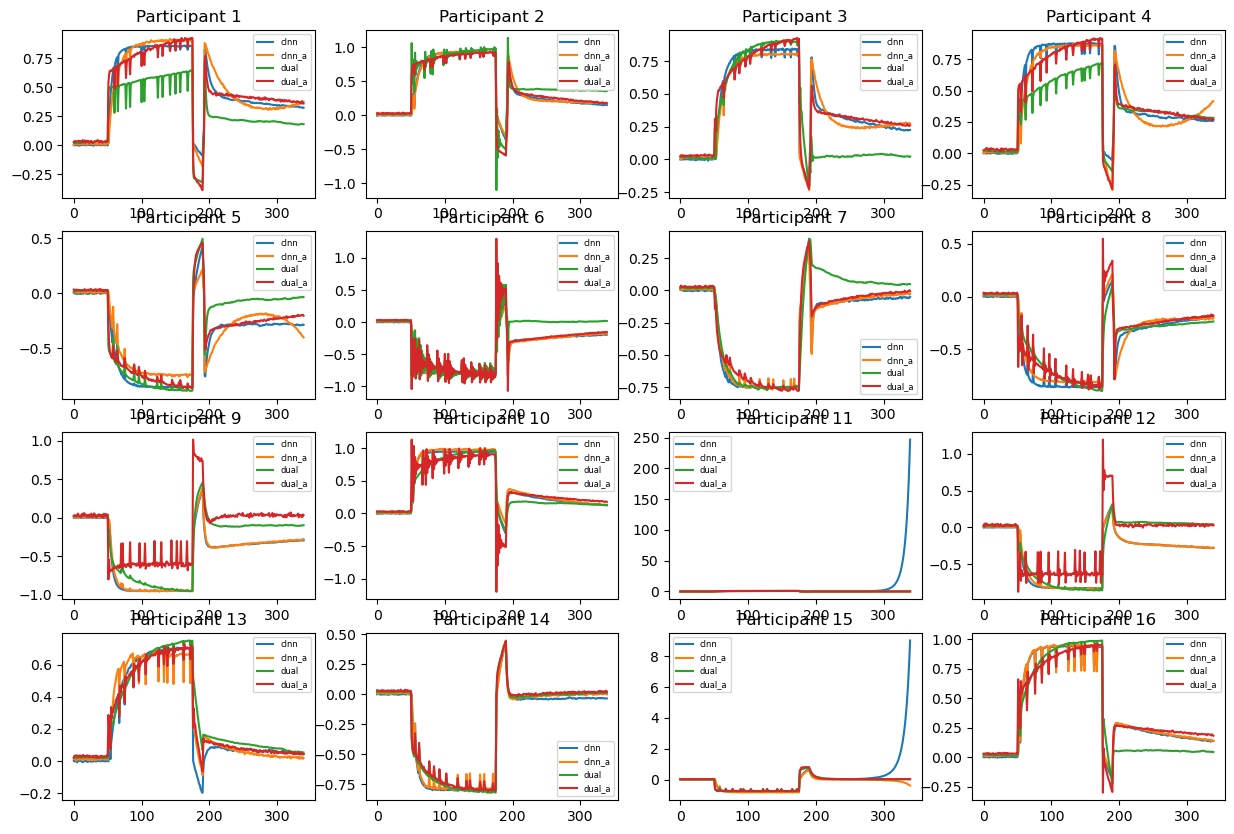

In [14]:
#subplot all the 16 participant results
plt.figure(figsize=(15,10))
for i in range(1,17):
    plt.subplot(4, 4, i)
    plt.title(f'Participant {i}')
    for mm, model_name in enumerate(run_specs.keys()):
        plt.plot(preds[model_name][i].mean(axis=-1)+mm*0.01, label=model_name)
    plt.legend(fontsize=6)


In [15]:
def create_dual_plots(mu_list_aligned, preds, preds_posterior, polarities, run_name):    
    plt.figure(figsize=(15,10))
    plt.subplot(2,1,1)
    for i in range(8):
        plt.plot(mu_list_aligned[i], color='gray', alpha=0.1, label = 'individual trials' if i==0 else None)
    mean_data = np.mean(mu_list_aligned[:8],axis=0)
    plt.plot(mean_data, label='mean', linewidth=3)
    ccc = FancyArrow(227,np.max(mean_data),
                      -30, -0, 
                      width=0.5*np.std(mean_data), 
                      length_includes_head=True, 
                      head_width=1*np.std(mean_data), 
                      head_length=10, 
                      color='red', 
                      alpha=0.5)
    plt.gca().add_patch(ccc)
    plt.text(230, np.max(mean_data), 'posterior mean is "kicked up"\n to enable a subsequent slow decay')
    
    plt.xlabel('trials')
    plt.ylabel('posterior mean of the latent white noise')
    plt.subplot(2,1,2)
    #plot predictions, aligned by polarity for evoked only
    all_pred_list = []
    for i in range(8):
        this_pred = preds[run_name][i+1].mean(axis=-1)*polarities[i+1]
        all_pred_list.append(this_pred)
        plt.plot(this_pred, color='tab:orange', alpha=0.1, label = 'individual subjects (prior)' if i==0 else None)
    plt.plot(np.mean(all_pred_list, axis=0), color='tab:orange', label='mean adaptation\n (noise sampled from prior)', linewidth=3)


    all_pred_list_post = []
    for i in range(8):
        this_pred_post = preds_posterior[run_name][i+1].mean(axis=-1)*polarities[i+1]
        all_pred_list_post.append(this_pred_post)
        plt.plot(this_pred_post, '--', color='tab:blue', alpha=0.1, label = 'individual subjects (posterior)' if i==0 else None)
    plt.plot(np.mean(all_pred_list_post, axis=0), color='tab:blue', label='mean adaptation\n (noise sampled from posterior)', linewidth=3)

    plt.xlabel('trials')
    plt.ylabel('adaptation')
    plt.legend()


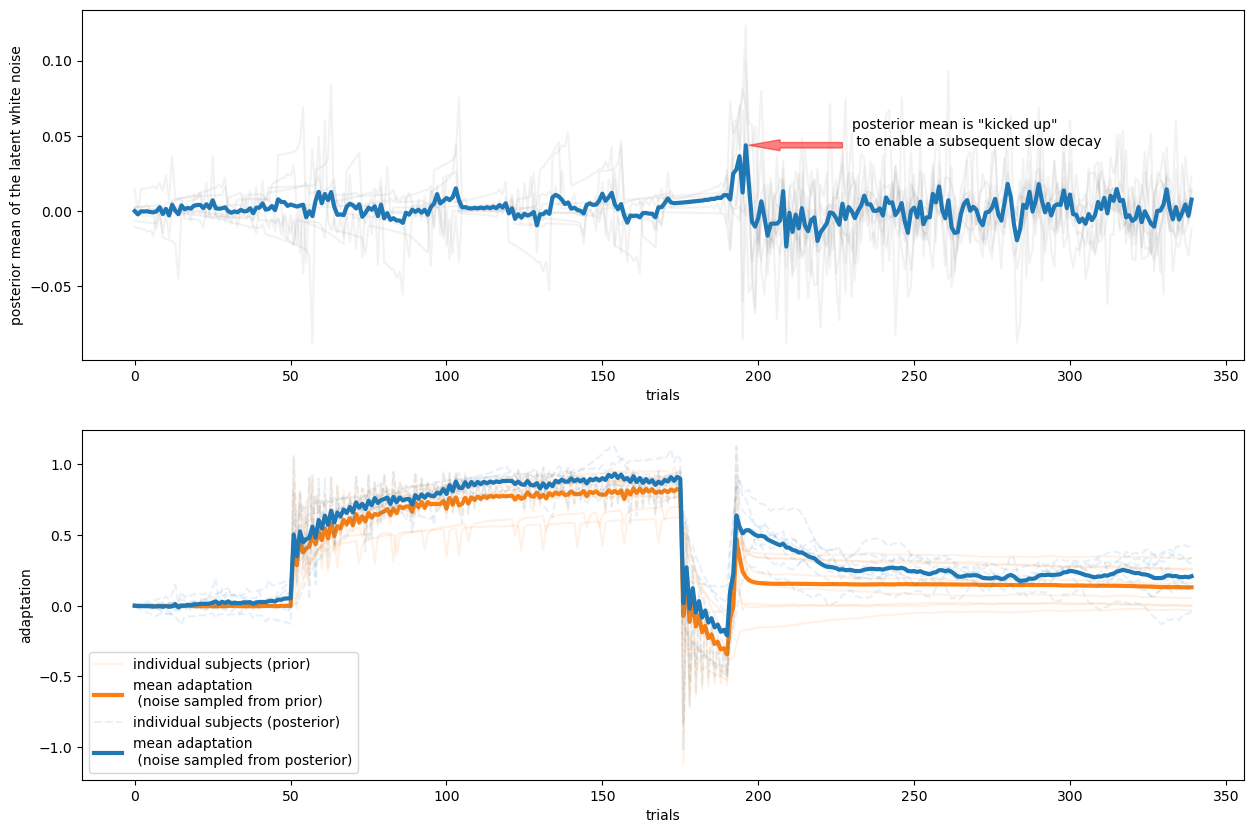

In [16]:
run_name = 'dual'
create_dual_plots(aux_data[run_name]['mu_list_aligned'], 
                  preds, 
                  preds_posterior, 
                  polarities, 
                  run_name)

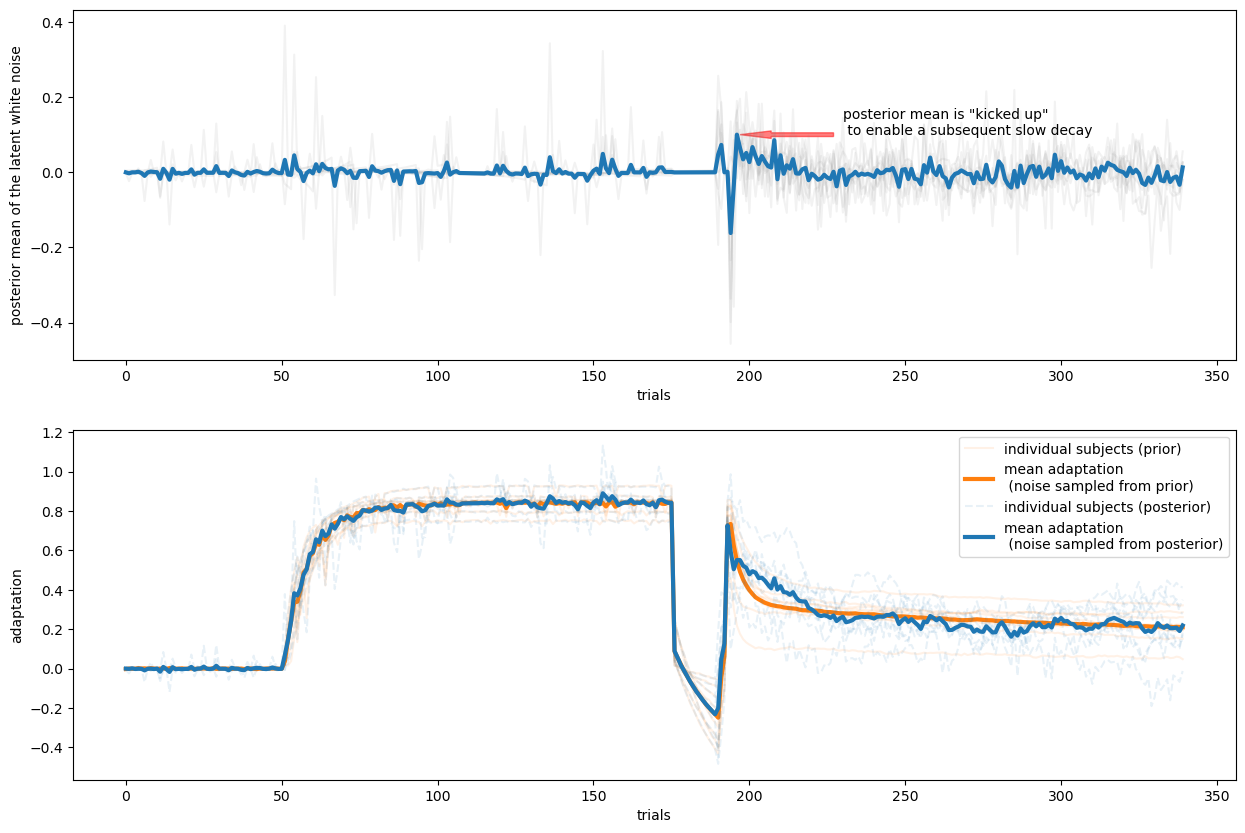

In [17]:
run_name = 'clnn'
create_dual_plots(aux_data[run_name]['mu_list_aligned'], 
                  preds, 
                  preds_posterior, 
                  polarities, 
                  run_name)

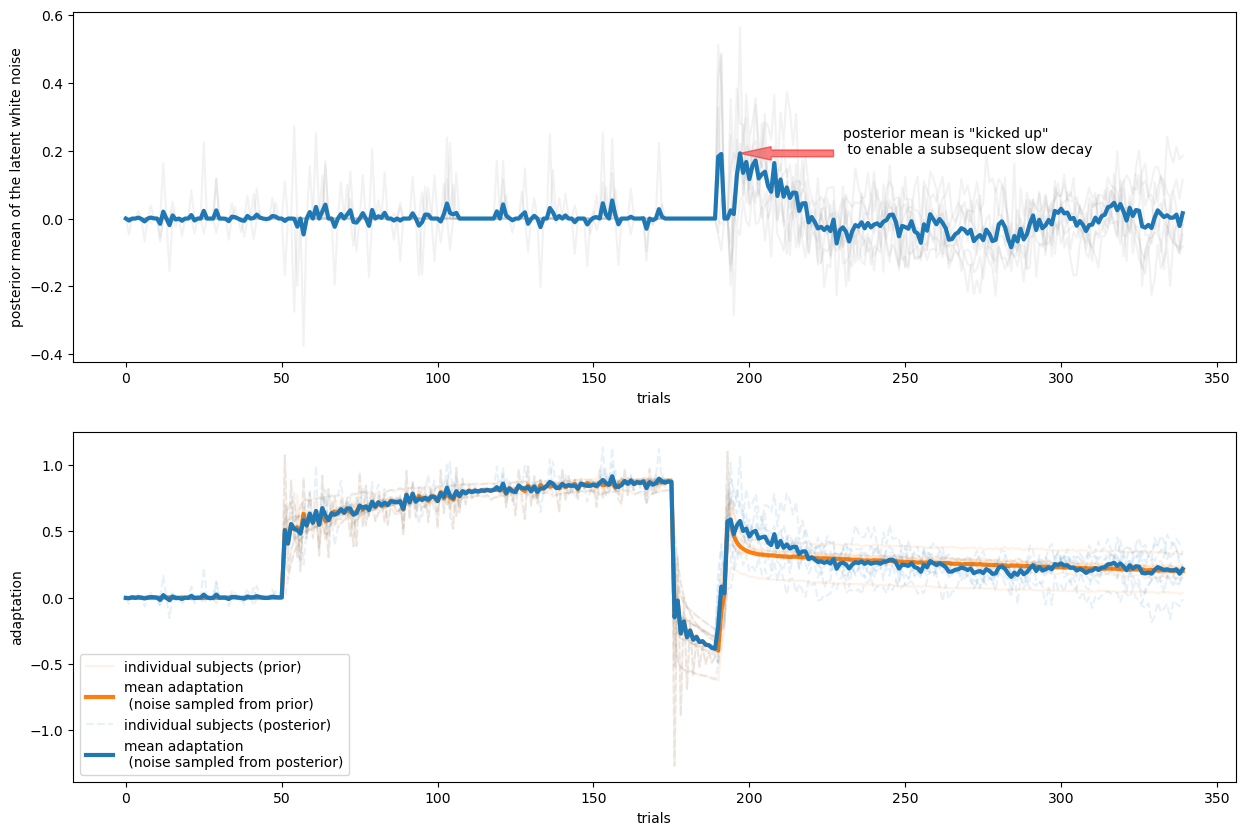

In [18]:
run_name = 'dual_a'
create_dual_plots(aux_data[run_name]['mu_list_aligned'], 
                  preds, 
                  preds_posterior, 
                  polarities, 
                  run_name)

In [19]:
aux_data['dual']['afast_list'], aux_data['dual']['aslow_list']

([array(0.50300443, dtype=float32),
  array(0.43118137, dtype=float32),
  array(-0.32605898, dtype=float32),
  array(0.5090543, dtype=float32),
  array(0.5364742, dtype=float32),
  array(-0.03917848, dtype=float32),
  array(-0.15943708, dtype=float32),
  array(0.6159436, dtype=float32),
  array(0.8204939, dtype=float32),
  array(0.62333053, dtype=float32),
  array(0.4998246, dtype=float32),
  array(0.464477, dtype=float32),
  array(0.0225895, dtype=float32),
  array(0.5870233, dtype=float32),
  array(0.63483644, dtype=float32),
  array(0.17629227, dtype=float32)],
 [array(0.9975306, dtype=float32),
  array(0.9988842, dtype=float32),
  array(0.9932477, dtype=float32),
  array(0.9975064, dtype=float32),
  array(0.99345976, dtype=float32),
  array(0.98582244, dtype=float32),
  array(0.98197746, dtype=float32),
  array(0.9985681, dtype=float32),
  array(0.9989436, dtype=float32),
  array(0.9985445, dtype=float32),
  array(0.9934573, dtype=float32),
  array(0.992628, dtype=float32),
  array

In [20]:
aux_data['dual']['afast_list'][:8]

[array(0.50300443, dtype=float32),
 array(0.43118137, dtype=float32),
 array(-0.32605898, dtype=float32),
 array(0.5090543, dtype=float32),
 array(0.5364742, dtype=float32),
 array(-0.03917848, dtype=float32),
 array(-0.15943708, dtype=float32),
 array(0.6159436, dtype=float32)]

In [21]:
len(aux_data[run_name]['mu_list_aligned'])

16

In [22]:
# load csv file into a numpy array
tail_errs = pd.read_csv('/homes/ar2342/frogs_project/COIN/examples/coin1K1KtailErrs.csv')
tail_errs = tail_errs.to_numpy()

In [23]:
tail_errs.shape

(15, 101)

In [24]:
def autocovariance(x,return_mean=True):
    '''
    for NxT array x, compute autocovariance along T for each of the N sequences
    autocovariance is defined as E[(X_t - mu)(X_{t+lag} - mu)]
       '''

    N, T = x.shape
    mu = np.mean(x, axis=1, keepdims=True)
    x_centered = x - mu

    autocov = np.zeros((N, T))
    for lag in range(T):
        autocov[:, lag] = np.mean(x_centered[:, :(-lag if -lag < 0 else None)] * x_centered[:, lag:], axis=1)

    if return_mean:
        return autocov.mean(axis=0)
    return autocov


In [25]:
def log10abs(x):
    return np.log10(np.abs(x))

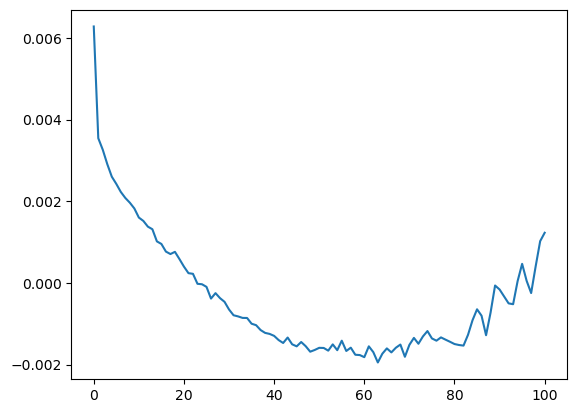

In [26]:
cov = autocovariance(tail_errs)
plt.plot(cov)

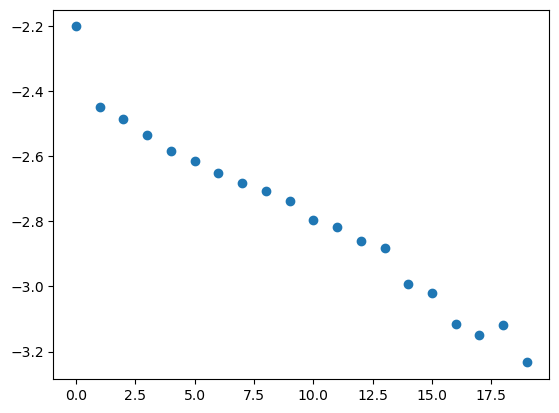

In [27]:
plt.plot(log10abs(cov[:20]),'o')

In [28]:
model_autocovs = {}
for this_arch in run_specs:

    model_autocovs[this_arch] = []
    for i in range(1,8+1):
        model_noises = preds[this_arch][i] - preds[this_arch][i].mean(axis=1, keepdims=True)
        model_noises += np.random.normal(0, sigmams[this_arch][i], size=model_noises.shape)
        model_tail_noises = model_noises[-101:-1,:].T #discard the last time point
        model_autocov = autocovariance(model_tail_noises)
        # plt.plot(log10abs(model_autocov)[:20],'o')
        model_autocovs[this_arch].append(model_autocov)

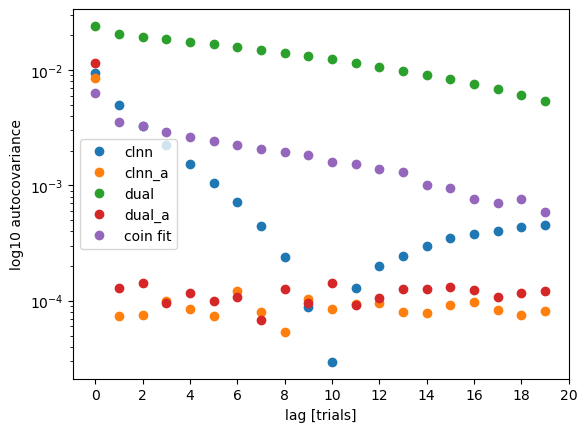

In [29]:
plt.figure()
# plt.plot(np.log10(np.array(model_autocovs)).T[:20,:],'.')
for this_arch in model_autocovs:
    _ = plt.semilogy(np.abs(np.mean(model_autocovs[this_arch], axis=0))[:20],'o',linewidth=3,label=this_arch)
_ = plt.semilogy(np.abs(cov[:20]),'o', label='coin fit')
plt.legend()
plt.xlabel('lag [trials]')
plt.ylabel('log10 autocovariance')
plt.gca().set_xticks(range(0,21,2))

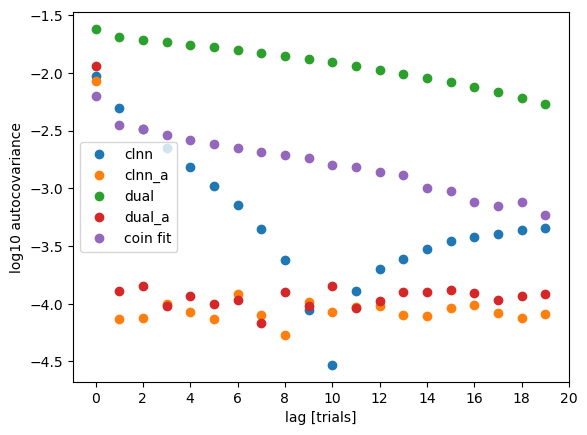

In [30]:
plt.figure()
# plt.plot(np.log10(np.array(model_autocovs)).T[:20,:],'.')
for this_arch in model_autocovs:
    _ = plt.plot(log10abs(np.mean(model_autocovs[this_arch], axis=0))[:20],'o',linewidth=3,label=this_arch)
_ = plt.plot(log10abs(np.abs(cov[:20])),'o', label='coin fit')
plt.legend()
plt.xlabel('lag [trials]')
plt.ylabel('log10 autocovariance')
plt.gca().set_xticks(range(0,21,2))

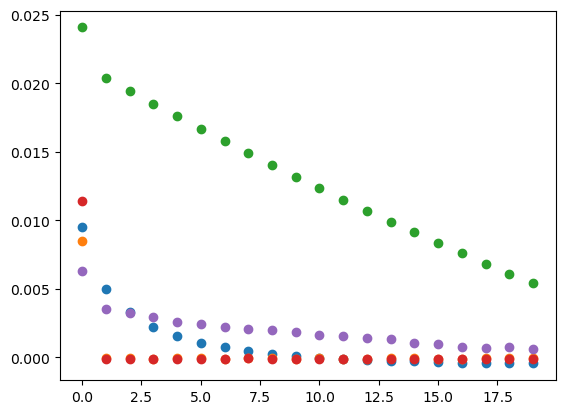

In [31]:
plt.figure()
# plt.plot(np.log10(np.array(model_autocovs)).T[:20,:],'.')
for this_arch in model_autocovs:
    plt.plot((np.mean(model_autocovs[this_arch], axis=0))[:20],'o',linewidth=3,label=this_arch)
plt.plot((np.abs(cov[:20])),'o',label='coin fit')